# PDF Framework

# Investigate changes in the Krill Growth Potential simulated by the CESM-LE

In [2]:
%matplotlib inline
import os
import shutil

from glob import glob

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean

import intake
import pop_tools

import util

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


## Spin up dask cluster

In [3]:
import dask

dask.config.set({'distributed.scheduler.allowed-failures': 3})

In [4]:
from ncar_jobqueue import NCARCluster
#cluster = NCARCluster()
cluster = NCARCluster(project='UCUC0006')
cluster.scale(36) #adapt(minimum_jobs=1, maximum_jobs=40)
cluster

In [5]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://10.12.205.14:33356 Dashboard: https://jupyterhub.ucar.edu/dav/user/zephyrs/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Get the model grid for subsetting in latitude
Where we are using the [pop_tools](https://pop-tools.readthedocs.io/en/latest/examples/get-model-grid.html) package. This reads the same binary files that the model read to generate the grid online.

In [6]:
grid = pop_tools.get_grid('POP_gx1v6')
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    DXU          (nlat, nlon) float64 2.397e+06 2.397e+06 ... 1.391e+06
    DYU          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.493e+06 5.493e+06
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
Attributes:
    lateral_dims:         [384, 320]
    vertical_dims:        60
    vert_grid_file:       gx1v7_vert_grid
    horiz_grid_fname:     inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ie...
    topography_fname:     inputdata/ocn/pop/gx1v6/grid/topography_20090204.ie...
    region_mask_fname:    inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.i...
    type:                 dipole
    region_mask_regions:  {'Caspian Sea': -14, 'Black Sea': -13, 'Baltic Sea'...
    title:                POP_gx1v6 grid

Find the portion of the domain that is south of 30°S.
Create a `slice` object corresponding to this region.

First, let's visualize the `TLAT` array.

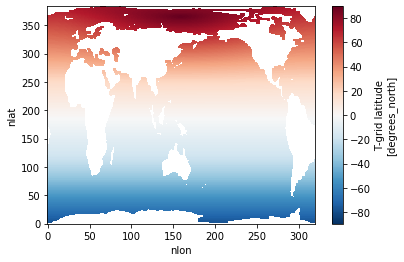

In [7]:
grid.TLAT.where(grid.KMT>0).plot();

The model is a regular lat x lon grid in the southern hemisphere, this we can just use the first column of the `TLAT` array; all other columns are identical.

In [8]:
jnx = np.where(grid.TLAT[:, 0] <= -30)[0]
lat_slice = slice(jnx[0], jnx[-1]+1)
lat_slice

slice(0, 93, None)

## Construct a region mask

In [9]:
# define a list of tuples describing our regions: (region_name, logical_array)
so_logic = (grid.TLAT <= -45)
mask_logic = [
    ('Southern Ocean', so_logic), 
    ('WAP & Atlantic', so_logic & ((grid.TLONG > 260) | (grid.TLONG < 25))),
    ('Indo-Pacific', so_logic & ~((grid.TLONG > 260) | (grid.TLONG < 25))),    
]

# create a region coordinate with the region names
region = xr.DataArray(
    [t[0] for t in mask_logic], 
    dims=('region'), 
)
nregion = len(region)


# create a masked array array
masked_area = xr.DataArray(
    np.zeros((nregion,)+grid.TLAT.shape), 
    dims=('region',)+grid.TLAT.dims,
    coords={'region': region},
    name='masked_area',
)
for i, name_logic in enumerate(mask_logic):
    masked_area.data[i, :, :] = grid.TAREA.where(name_logic[1]).fillna(0.).where(grid.KMT>0)

# subset to the lat range from above
masked_area = masked_area.isel(nlat=lat_slice)
masked_area    

<xarray.DataArray 'masked_area' (region: 3, nlat: 93, nlon: 320)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.52530781e+13, 1.52530781e+13, 1.52530781e+13, ...,
                    nan,            nan,            nan],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.52530781e+13, 1.52530781e+13, 1.52530781e+13, ...,
                    nan,            nan,            nan],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                    nan,            nan,            nan],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * region   (region) <U14 'Southern Ocean' 'WAP & Atlantic' 'Indo-Pacific'
Dimensions without coordinates: nlat, nlon

Make a quick-look plot of the regions.

In [10]:
'''ncol = int(np.sqrt(nregion))
nrow = int(nregion/ncol) + min(1, nregion%ncol)

fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                       constrained_layout=True)

for i, region in enumerate(masked_area.region.values):
    plt.axes(ax.ravel()[i])
    masked_area.sel(region=region).plot()  '''  

'ncol = int(np.sqrt(nregion))\nnrow = int(nregion/ncol) + min(1, nregion%ncol)\n\nfig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),\n                       constrained_layout=True)\n\nfor i, region in enumerate(masked_area.region.values):\n    plt.axes(ax.ravel()[i])\n    masked_area.sel(region=region).plot()  '

Check that the sum across the region dimension is as expected. Land should have the value `nregion` and elsewhere the coverage should reflect the number of regions the cover each cell, e.g., if there is no overlap, the plot should show "1".

In [11]:
#masked_area.where(masked_area==0).fillna(1.).sum('region').plot();

## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [12]:
catalog_file = './data/glade-cesm1-le.json'
variables = ['SST', 'diatChl', 'spChl', 'diazChl', 'IFRAC']
experiments = ['20C', 'RCP85']
stream = 'pop.h'
    
col = intake.open_esm_datastore(catalog_file)
#col

Now we will search the collection for the ensemble members (unique `member_id`'s) that have a chlorophyll field. This is necessary because the ocean biogeochemistry was corrupted in some members and the data deleted.

In this cell, `member_id` is a list of the ensemble members we want to operate on.

In [13]:
col_sub = col.search(experiment=['20C'],                      
                     stream='pop.h', 
                     variable=['diatChl'])

member_id = list(col_sub.df.member_id.unique())
#print(member_id)

## Now let's search for the data we want

Specify a list of variables and perform a search. Under the hood, the `search` functionality uses [`pandas`](https://pandas.pydata.org/) data frames. We can view that frame here using the `.df` syntax.

In [14]:
col_sub = col.search(
    experiment=experiments, 
    stream=stream, 
    variable=variables,
    member_id=member_id,
    )

#print(col_sub)

#col_sub.df.head()

Now we can use the [`to_dataset_dict`](https://intake-esm.readthedocs.io/en/latest/api.html#intake_esm.core.esm_datastore.to_dataset_dict) method to return a dictionary of `xarray.Dataset`'s. `intake_esm` makes groups of these according to rules in the collection spec file.

We can use the `preprocess` parameter to pass in a function that makes some corrections to the dataset. So first we define a function that does the following:
- fix the time coordinate to be the middle of the interval
- drop the singleton dimension on SST (which screws up coordinate alignment)
- subset to the time-interval 1920-2100

In [15]:
def fix_sst_time_and_subset(ds):
    """Fix some things in the dataset and subset in space"""   
    grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time', 'time_bound']

    if 'SST' in ds:
        ds['SST'] = ds.SST.isel(z_t=0, drop=True)
             
    data_vars = list(filter(lambda v: v in variables, ds.data_vars))
    
    ds = ds[data_vars+grid_vars].isel(nlat=lat_slice)
    
    # set grid variables to coordinates to ease concatenation in intake-esm
    new_coords = set(grid_vars) - set(ds.coords)

    return ds.set_coords(new_coords)

In [16]:
%%time
dsets = col_sub.to_dataset_dict(cdf_kwargs={'chunks': {'time': 60}, 'decode_times': False},
                                preprocess=fix_sst_time_and_subset)
#dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'
                
--> There is/are 2 group(s)
CPU times: user 3.65 s, sys: 504 ms, total: 4.15 s
Wall time: 1min 43s


Now, let's compute the total surface chlorophyll, put time at the mid-point of the interval, and subset to 1920-2100.

In [17]:
def compute_chl_surf(ds):
    """compute surface chl"""

    ds['Chl_surf'] = (ds.diatChl + ds.spChl + ds.diazChl).isel(z_t_150m=0)
    ds.Chl_surf.attrs = ds.diatChl.attrs
    ds.Chl_surf.attrs['long_name'] = 'Surface chlorophyll'

    return ds.drop(['diatChl', 'spChl', 'diazChl'])


def fix_time(ds):
    ds = ds.copy(deep=True)
    ds['time'] = xr.DataArray(cftime.num2date(ds.time_bound.mean(dim='d2'), units=ds.time.units, 
                                              calendar=ds.time.calendar), dims=('time'))
    return ds    

In [18]:
# fix time
dsets2 = {key: fix_time(ds) for key, ds in dsets.items()}

# subset time
dsets2 = {key: ds.sel(time=slice('1920', '2100')) for key, ds in dsets2.items()}

# compute surface chl
dsets2 = {key: compute_chl_surf(ds) for key, ds in dsets2.items()}

#dsets2

Concatenate the datasets in time, i.e. 20C + RCP8.5 experiments.

In [19]:
ordered_dsets_keys = ['ocn.20C.pop.h', 'ocn.RCP85.pop.h']
ds = xr.concat(
    [dsets2[exp] for exp in ordered_dsets_keys],
    dim='time',
    data_vars='minimal'
).chunk({'time': 900})

## Compute Krill Growth Potential

First, make a function that computes the krill daily growth rate model.

In [20]:
def compute_kgp(ds, length):
    """Compute Krill Growth Potential 
    
    Natural growth rates in Antarctic krill (Euphausia superba): II. Predictive 
    models based on food, temperature, body length, sex, and maturity 
    stage.[Model 3 (Table 5)]. doi: 10.4319/lo.2006.51.2.0973 
    A Atkinson, RS Shreeve, AG Hirst, P Rothery, GA Tarling 
    Limnol Oceanogr, 2006 
    
    Oceanic circumpolar habitats of Antarctic krill 
    doi: 10.3354/meps07498 
    A Atkinson, V Siegel, EA Pakhomov, P Rothery, V Loeb 
    Mar Ecol Prog Ser, 2008
    
    """
    # specify coefs
    a = -0.066 # Constant - all krill combined (no life stage or sex)
    b = 0.002 # Linear term relating to length
    c = -0.000061 # Quadratic term relating to length
    d = 0.385 # Maximum term relating to food
    e = 0.328 # Half Saturation constant relating to food
    f = 0.0078 # Linear term relating to temperature
    g = -0.0101 # Quadratic term relating to temperature
    
    # local pointers
    sst = ds.SST
    chl = ds.Chl_surf
    ice = ds.IFRAC
            
    # compute terms and sum for: a + b * length + c * length^2 + [d * chl / (e + chl)] + f * SST + g * SST^2 (+ error)
    length_term = a + (b * length) + (c * length**2)
    chl_term = d * chl / (e + chl)    
    sst_term = f * sst + g * sst**2    
    kgp = length_term + chl_term + sst_term
    kgp.name = 'KGP'
    
    # mask based on SST range
    #kgp = kgp.where((-1. <= sst) & (sst <= 5.)).fillna(0.).where(ds.KMT > 0)
    kgp = kgp.where((-1. <= sst) & (sst <= 5.) & (0.15 <= ice)).fillna(0.).where(ds.KMT > 0)

    # add coordinates
    kgp = kgp.assign_coords({'length': length})
    kgp = kgp.assign_coords({'TLONG': ds.TLONG, 'TLAT': ds.TLAT})

    # add attrs
    kgp.attrs = {'units': 'mm d$^{-1}$', 'long_name': 'Daily growth rate'}
    ds['KGP'] = kgp
    return ds

Define a "length" coordinate.

In [21]:
length = xr.DataArray(
    [20., 30., 40., 50,], 
    name='length',
    dims=('length'), 
    attrs={'units': 'mm', 'long_name': 'Krill body length'})
#length

Perform the actual computation

In [22]:
ds = compute_kgp(ds, length)
#ds

## Compute summer time (DJF) means 

In [23]:
%%time
#ds_djf = util.ann_mean(ds, season='DJF', time_bnds_varname='time_bound')
ds_djf = util.ann_mean(ds, season='DJF', time_bnds_varname='time_bound').chunk({'time': -1})
ds_djf

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 34
  **blockwise_kwargs,
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 34
  **blockwise_kwargs,
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 34
  **blockwise_kwargs,
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 34
  **blockwise_kwargs,


CPU times: user 11.4 s, sys: 714 ms, total: 12.1 s
Wall time: 18.4 s


<xarray.Dataset>
Dimensions:    (length: 4, member_id: 34, nlat: 93, nlon: 320, time: 180, z_t: 60, z_t_150m: 15)
Coordinates:
    dz         (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * z_t_150m   (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * length     (length) float64 20.0 30.0 40.0 50.0
  * z_t        (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon
Data variables:
    IFRAC      (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, length, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 4, 1, 93, 320), meta=np.ndarray>

## Compute Trend Windows

In [24]:
def linear_trend(da, dim='time'):
    da_chunk = da.chunk({dim: -1})
    trend = xr.apply_ufunc(calc_slope,
                           da_chunk,
                           vectorize=True,
                           input_core_dims=[[dim]],
                           output_core_dims=[[]],
                           output_dtypes=[np.float],
                           dask='parallelized')
    return trend

def calc_slope(y):
    """ufunc to be used by linear_trend"""
    x = np.arange(len(y))
    return np.polyfit(x, y, 1)[0]

to use the `linear_trend` function, data must be in arrays:

In [25]:
kgp_early = ds_djf['KGP'].sel(time=slice('1920', '1949')).sel(length=40)
kgp_late = ds_djf['KGP'].sel(time=slice('2070', '2099')).sel(length=40)
kgp_veytia = ds_djf['KGP'].sel(time=slice('1960', '1989')).sel(length=40) # “historical” (1960-1989) to compare to Veytia et al
kgp_murphy = ds_djf['KGP'].sel(time=slice('1985', '2005')).sel(length=40) # “modern” (1985-2005) to compare to Murphy

In [26]:
with xr.set_options(keep_attrs=True):   
    trend_windows = [
        ('1920-1950', linear_trend(kgp_early)),
        ('1960-1989', linear_trend(kgp_veytia)),
        ('1985-2005', linear_trend(kgp_murphy)),
        ('2070-2100', linear_trend(kgp_late)),
         ]
         
trend = xr.DataArray(
    [t[0] for t in trend_windows],
    dims=('trend'),
    name='trend',
)    

ds_djf_trends = xr.concat(
    [t[1] for t in trend_windows], 
    dim=trend,
)
ds_djf_trends = ds_djf_trends.compute()
ds_djf_kgp_trends

<xarray.DataArray 'KGP' (trend: 4, member_id: 34, nlat: 93, nlon: 320)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-6.50629073e-05, -3.25136963e-05, -4.98360373e-05, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.37627007e-04,  9.84895222e-05,  1.09697839e-04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.62605814e-05, -2.11576366e-06, -1.58181157e-04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        ...,

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.43118322e-04, -8.07322278e-05, -4.90089756e-05, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-7.31950311e-05, -2.28609818e-05,  5.51574152e-05, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [31]:
sst_5 = ds_djf['SST'].sel(time=slice('2005', '2010'))
sst_10 = ds_djf['SST'].sel(time=slice('2005', '2015'))
sst_30 = ds_djf['SST'].sel(time=slice('2005', '2035'))
sst_50 = ds_djf['SST'].sel(time=slice('2005', '2055'))

In [32]:
chl_5 = ds_djf['Chl_surf'].sel(time=slice('2005', '2010'))
chl_10 = ds_djf['Chl_surf'].sel(time=slice('2005', '2015'))
chl_30 = ds_djf['Chl_surf'].sel(time=slice('2005', '2035'))
chl_50 = ds_djf['Chl_surf'].sel(time=slice('2005', '2055'))

In [33]:
ice_5 = ds_djf['IFRAC'].sel(time=slice('2005', '2010'))
ice_10 = ds_djf['IFRAC'].sel(time=slice('2005', '2015'))
ice_30 = ds_djf['IFRAC'].sel(time=slice('2005', '2035'))
ice_50 = ds_djf['IFRAC'].sel(time=slice('2005', '2055'))

In [34]:
kgp_5 = ds_djf['KGP'].sel(time=slice('2005', '2010')).sel(length=40)
kgp_10 = ds_djf['KGP'].sel(time=slice('2005', '2015')).sel(length=40)
kgp_30 = ds_djf['KGP'].sel(time=slice('2005', '2035')).sel(length=40)
kgp_50 = ds_djf['KGP'].sel(time=slice('2005', '2055')).sel(length=40)

In [35]:
with xr.set_options(keep_attrs=True):   
    trend_windows = [
        ('2005-2010', linear_trend(kgp_5)),
        ('2005-2015', linear_trend(kgp_10)),
        ('2005-2035', linear_trend(kgp_30)),
        ('2005-2055', linear_trend(kgp_50)),
         ]
         
trend = xr.DataArray(
    [t[0] for t in trend_windows],
    dims=('trend'),
    name='trend',
)    

ds_djf_trends = xr.concat(
    [t[1] for t in trend_windows], 
    dim=trend,
)
ds_djf_trends = ds_djf_trends.compute()
ds_djf_kgp_trends = ds_djf_trends

NameError: name 'ds_djf_kgp_trends' is not defined

In [36]:
ds_djf_kgp_trends = ds_djf_trends

In [37]:
with xr.set_options(keep_attrs=True):   
    trend_windows = [
        ('2005-2010', linear_trend(chl_5)),
        ('2005-2015', linear_trend(chl_10)),
        ('2005-2035', linear_trend(chl_30)),
        ('2005-2055', linear_trend(chl_50)),
         ]
         
trend = xr.DataArray(
    [t[0] for t in trend_windows],
    dims=('trend'),
    name='trend',
)    

ds_djf_trends = xr.concat(
    [t[1] for t in trend_windows], 
    dim=trend,
)
ds_djf_chl_trends = ds_djf_trends.compute()
ds_djf_chl_trends

<xarray.DataArray 'Chl_surf' (trend: 4, member_id: 34, nlat: 93, nlon: 320)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.13988534e-02,  2.77883642e-02,  2.67474934e-02, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [-1.75610205e-04, -2.34081731e-04, -2.26916546e-04, ...,
          -1.88497425e-05, -5.96598562e-05, -1.11557653e-04],
         [-1.92645296e-04, -2.52875355e-04, -2.44001927e-04, ...,
          -4.77420548e-05, -7.40425427e-05, -1.24993333e-04],
         [-2.20119984e-04, -2.69841425e-04, -2.68861892e-04, ...,
          -8.02849359e-05, -1.08390687e-04, -1.70404381e-04]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-9.69970058e-02, -9.85808044e-02, -9.72709716e-02, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 9.81210819e-05,  1.04364617e-04,  1.31951261e-04, ...,
           5.69517384e-05,  8.07992621e-05,  9.46549789e-05],
         [ 9.71758421e-05,  9.78883818e-05,  1.30656960e-04, ...,
           9.80863524e-05,  1.27618229e-04,  1.18202858e-04],
         [ 7.22740823e-05,  5.85134118e-05,  9.69217680e-05, ...,
           1.56527769e-04,  1.47034333e-04,  1.09449107e-04]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.51785998e-02,  3.30010079e-02,  3.03907821e-02, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 1.53661217e-04,  1.36213480e-04,  8.81227148e-05, ...,
           1.93302314e-04,  2.07465514e-04,  1.81360369e-04],
         [ 1.07820627e-04,  9.49778147e-05,  3.38267410e-05, ...,
           1.76376739e-04,  1.70234202e-04,  1.22516431e-04],
         [ 5.87884822e-05,  4.59446029e-05,  8.50879136e-06, ...,
           1.31015589e-04,  1.05652450e-04,  6.11325978e-05]],

        ...,

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.83126900e-02,  3.29835605e-02,  3.38516391e-02, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [-1.80506000e-06,  3.76475716e-05,  1.04597495e-04, ...,
          -7.15027841e-05, -6.11084497e-05, -3.49159520e-05],
         [ 1.97495693e-05,  7.59105205e-05,  1.59574980e-04, ...,
          -4.78477163e-05, -5.36332804e-05, -2.12746610e-05],
         [ 4.17096398e-05,  8.24881299e-05,  1.34022202e-04, ...,
          -5.35813587e-05, -4.85275202e-05, -2.63735412e-06]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.39029900e-01, -1.35587779e-01, -1.36675317e-01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [-4.58910588e-04, -4.62930127e-04, -4.64589896e-04, ...,
          -2.05338463e-04, -3.54437514e-04, -4.31599009e-04],
         [-5.55387945e-04, -5.60506221e-04, -5.43611165e-04, ...,
          -2.88084829e-04, -4.40043157e-04, -5.14986092e-04],
         [-5.94398199e-04, -6.25469808e-04, -6.12331276e-04, ...,
          -3.30911039e-04, -4.65567442e-04, -5.482498

In [38]:
with xr.set_options(keep_attrs=True):   
    trend_windows = [
        ('2005-2010', linear_trend(sst_5)),
        ('2005-2015', linear_trend(sst_10)),
        ('2005-2035', linear_trend(sst_30)),
        ('2005-2055', linear_trend(sst_50)),
         ]
         
trend = xr.DataArray(
    [t[0] for t in trend_windows],
    dims=('trend'),
    name='trend',
)    

ds_djf_trends = xr.concat(
    [t[1] for t in trend_windows], 
    dim=trend,
)
ds_djf_sst_trends = ds_djf_trends.compute()
ds_djf_sst_trends

<xarray.DataArray 'SST' (trend: 4, member_id: 34, nlat: 93, nlon: 320)>
array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.06165147,  0.06474713,  0.06542955, ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.01471555,  0.01808553,  0.02006098, ...,  0.00892244,
           0.00917988,  0.01117287],
         [ 0.01510376,  0.01870975,  0.02099818, ...,  0.00950213,
           0.00978171,  0.01158496],
         [ 0.01581957,  0.01936753,  0.02175541, ...,  0.01061174,
           0.01131222,  0.01292417]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.00697741,  0.00796001,  0.00837693, ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.03661709,  0.0362954 ,  0.03583687, ...,  0.04062714,
           0.0391684 ,  0.03750985],
         [ 0.03174144,  0.0319223 ,  0.03122822, ...,  0.03625712,
           0.03370795,  0.03222829],
         [ 0.02713533,  0.02720855,  0.02596904, ...,  0.03108596,
           0.02863351,  0.02741385]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.02803041,  0.03139318,  0.034479  , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.01982579,  0.01678371,  0.01564762, ...,  0.02060408,
           0.02120136,  0.02164099],
         [ 0.02072132,  0.01799699,  0.0170451 , ...,  0.022056  ,
           0.0231809 ,  0.02321264],
         [ 0.0222213 ,  0.01973972,  0.01822719, ...,  0.02451216,
           0.02553973,  0.02479205]],

        ...,

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [-0.09898449, -0.09966822, -0.10017726, ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.01601556,  0.01270773,  0.01017947, ...,  0.01177932,
           0.01517652,  0.01717463],
         [ 0.01494724,  0.01111126,  0.00901931, ...,  0.01177224,
           0.01542435,  0.01709444],
         [ 0.01383502,  0.0108233 ,  0.00990213, ...,  0.0127817 ,
           0.0162189 ,  0.01657103]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.00190159,  0.00228458,  0.00206709, ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [-0.00681807,  0.00017434,  0.00677837, ..., -0.01527548,
          -0.01400678, -0.0116526 ],
         [-0.00353158,  0.00419583,  0.0105987 , ..., -0.01490388,
          -0.01328087, -0.00988011],
         [-0.0006798 ,  0.00773014,  0.01340688, ..., -0.01456441,
          -0.01284572, -0.00814955]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.01810542,  0.02104667,  0.0234258 , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [-0.00376366, -0.00130419,  0.00078657, ..., -0.00393687,
          -0.00548071, -0.00538007],
         [-0.00336817, -0.00061037,  0.00172457, ..., -0.00376021,
          -0.00556512, -0.0053169 ],
         [-0.0011669 ,  0.00138836,  0.00370469, ..., -0.00293594,
          -0.00343856, -0.0028053 ]]],


       [[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
     

In [39]:
with xr.set_options(keep_attrs=True):   
    trend_windows = [
        ('2005-2010', linear_trend(ice_5)),
        ('2005-2015', linear_trend(ice_10)),
        ('2005-2035', linear_trend(ice_30)),
        ('2005-2055', linear_trend(ice_50)),
         ]
         
trend = xr.DataArray(
    [t[0] for t in trend_windows],
    dims=('trend'),
    name='trend',
)    

ds_djf_trends = xr.concat(
    [t[1] for t in trend_windows], 
    dim=trend,
)
ds_djf_ice_trends = ds_djf_trends.compute()
ds_djf_ice_trends

<xarray.DataArray 'IFRAC' (trend: 4, member_id: 34, nlat: 93, nlon: 320)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.79903155e-02, -2.02592531e-02, -1.77334217e-02, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-6.30609312e-03, -8.18944968e-03, -7.55154417e-03, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.25962874e-02, -1.39435781e-02, -1.74413507e-02, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        ...,

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.93737319e-02,  2.88182195e-02,  2.83658637e-02, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.50283897e-04,  2.37739758e-03,  5.79379589e-03, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e

In [30]:
ds_djf

<xarray.Dataset>
Dimensions:    (length: 4, member_id: 34, nlat: 93, nlon: 320, time: 180, z_t: 60, z_t_150m: 15)
Coordinates:
    dz         (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * z_t_150m   (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * length     (length) float64 20.0 30.0 40.0 50.0
  * z_t        (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon
Data variables:
    IFRAC      (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, length, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 4, 1, 93, 320), meta=np.ndarray>

In [40]:
dso_map = {
    'data/trend-rd1-sst.zarr': ds_djf_sst_trends, 
    'data/trend-rd1-chl.zarr': ds_djf_chl_trends,
    'data/trend-rd1-ice.zarr': ds_djf_ice_trends,  
    'data/trend-rd1-kgp.zarr': ds_djf_kgp_trends,  

}
for file_out, dso in dso_map.items():
    util.write_ds_out(dso, file_out)


------------------------------
Writing /glade/u/home/zephyrs/projects/krill-cesm-le/notebooks/data/trend-rd1-sst.zarr


AttributeError: 'DataArray' object has no attribute 'info'

In [44]:
dso_map = {
    #'data/trend-rd1-sst.zarr': ds_djf_sst_trends, 
    #'data/trend-rd1-chl.zarr': ds_djf_chl_trends,
    #'data/trend-rd1-ice.zarr': ds_djf_ice_trends,  
    'data/trend-rd1-kgp.zarr': ds_djf_kgp_trends,
}
for file_out, dso in dso_map.items():
    util.write_ds_out(dso, file_out)

------------------------------
Writing /glade/u/home/zephyrs/projects/krill-cesm-le/notebooks/data/trend-rd1-kgp.zarr


AttributeError: 'DataArray' object has no attribute 'info'

In [42]:
dsi = ds_djf_sst_trends
file_out = 'data/trend-rd1-sst.zarr'
if os.path.exists(file_out):
    shutil.rmtree(file_out)
dsi.to_zarr(file_out);


AttributeError: 'DataArray' object has no attribute 'to_zarr'